17/Jan/2024

# Ground Point Filtering

### Check how many points in the laz file 
### Check how many ground points base on AHN classification
### Get the lowest points
### Form the original TIN by lowest points and find other ground points
### Build the TIN and use it
### Save data to csv and laz files
### Review Threshold settings
### Threshold Finding Method
### Conclusion

## Check how many points in the laz file 

Laz file is 600×600m, thinned + removing outlier one 

In [1]:
import laspy
import numpy as np

def count_points_in_laz(file_path):
    las_file = laspy.open(file_path, mode='r')
    num_points = las_file.header.point_records_count
    las_file.close()
    print(f"The .laz file has {num_points} points.")

laz_file_path = "600_thinned_025_filtered.laz"
count_points_in_laz(laz_file_path)


The .laz file has 1823402 points.


## Check how many ground points base on AHN classification

Just to remember the number

In [2]:
import laspy

def count_ground_points(file_path):

    with laspy.open(file_path) as f:
        
        laz_data = f.read()
        ground_points = laz_data.points[laz_data.classification == 2]
        
        return len(ground_points)

file_path = "600_thinned_025_filtered.laz"
num_ground_points = count_ground_points(file_path)
print(f"Ground points count: {num_ground_points}")

Ground points count: 1516921


## Get the lowest points

In [3]:
import numpy as np
import laspy

def read_laz_file(file_path):
    las = laspy.read(file_path)
    points = np.vstack((las.x, las.y, las.z)).transpose()
    return points

def create_grid_and_find_lowest_points(points, grid_size):
    
    # These two lines calculate the minimum and maximum x and y coordinates among all points. 
    # This is used to determine the extent of the grid.
    min_x, min_y, _ = np.min(points, axis=0)
    max_x, max_y, _ = np.max(points, axis=0)
    print("min_x, min_y: ", min_x, min_y)
    print("max_x, max_y: ", max_x, max_y)
    
    # Create grid
    # These two lines create a sequence of x and y coordinates that represent the positions of the grid lines, 
    # plus grid_size for later use. grid_size is the size of the grid cells.
    x_coords = np.arange(min_x, max_x, grid_size)
    y_coords = np.arange(min_y, max_y, grid_size)

    lowest_points = []
    for x in x_coords:
        for y in y_coords:
            # Find the point in the grid
            in_grid = (points[:, 0] >= x) & (points[:, 0] < x + grid_size) & \
                      (points[:, 1] >= y) & (points[:, 1] < y + grid_size)
            grid_points = points[in_grid]

            if len(grid_points) > 0:
                # Select the point with the smallest z value
                lowest_point = grid_points[np.argmin(grid_points[:, 2])]
                lowest_points.append(lowest_point)
            else:
                # Print the position of the grid without data
                print(f"No data in grid at position: x={x}, y={y}")

    return np.array(lowest_points)

grid_size = 40  # Maximum building 33x33m
input_laz_path = "600_thinned_025_filtered.laz"
points=read_laz_file(input_laz_path)
lowest_points = create_grid_and_find_lowest_points(points, grid_size)

print(len(lowest_points)) #If =225, there is no cell with no data


min_x, min_y:  188415.0 311750.0
max_x, max_y:  189015.0 312350.0
225


## Form the original TIN by lowest points and find other ground points

This code includes constructing a TIN, using multiple points to generate a TIN, and inserting points one by one. There are comments below.
The output is an array named results, which has a structure such as


[(array([1.88684583e+05, 3.12241676e+05, 1.18058000e+02]),
   3.200938809162494,
   18.425626067846835,
   False),
  (array([1.88728947e+05, 3.12121377e+05, 1.12656000e+02]),
   0.1345523416530341,
   0.620972773517833,
   True),.....
   
The 0th is the coordinate, the 1st is the distance, the 2nd is alpha, and the Boolean value is whether is inserted or not.
   

In [5]:
import matplotlib.pyplot as plt
import startinpy
from tqdm import tqdm

class Tin:
    def __init__(self):
        self.dt = startinpy.DT()
        
    def insert_lowest_pts(self,arr): # insert a lot of point at the same time and create TIN
        return self.dt.insert(arr)

    def number_of_vertices(self):
        return self.dt.number_of_vertices()

    def number_of_triangles(self):
        return self.dt.number_of_triangles()

    def insert_ground_pt(self, point): # insert a point
        x=point[0]
        y=point[1]
        z=point[2]
        return self.dt.insert_one_pt(x, y, z)
    
    def insert_one_pt(self, x, y, z):
        self.dt.insert_one_pt(x, y, z)


    def info(self):
        print(self.dt.points)

    def get_delaunay_vertices(self):
        return self.dt.points
    
    def get_triangles(self):
        return self.dt.triangles
    
    
    def get_location(self,point): # get the point is located in which triangle 
        x=point[0]
        y=point[1]
        return self.dt.locate(x,y)
    
    
        """    
    def get_all_triangle_index(self):
        pts = self.dt.points
        edges = []
        for tr in self.dt.triangles:
            
            a = tr            
            edges.append(a)

        return edges
        
        """

    def get_p123(self,arr): # get the coordinate from the index
        pts=self.dt.points
        p123=[]
        

        a=pts[arr[0]]
        b=pts[arr[1]]
        c=pts[arr[2]]

        p123.append(a)
        p123.append(b)
        p123.append(c)
            
        return p123
    
    def is_inside_tin(self,point): 
        # check the point is inside the tin or not 
        # convex hull is formed by the lowest points
        
        x=point[0]
        y=point[1]
        
        return self.dt.is_inside_convex_hull(x,y)

    def find_distance_and_add_points(self, points): # main function 
        results = []

        for point in tqdm(points, desc="Processing points"):
            
            inside_index = self.is_inside_tin(point)
    
            if not inside_index:
                results.append((point, None, None, False))  # not inside TIN
                continue

            arr = self.get_location(point)
            p123 = self.get_p123(arr)
            p1, p2, p3 = p123[0], p123[1], p123[2]
            
            # Calculate distance
            normal_vector = np.cross(p2 - p1, p3 - p1)
            normal_vector /= np.linalg.norm(normal_vector)
            a, b, c = normal_vector
            d = -np.dot(normal_vector, p1)
            distance = abs(a * point[0] + b * point[1] + c * point[2] + d) / np.linalg.norm(normal_vector)

            # Calculate alpha
            vectors = [point - p1, point - p2, point - p3]
            max_angle = 0

            for v in vectors:
                norm_v = np.linalg.norm(v)
                if norm_v == 0:
                    # print("the same point")
                    continue

                v /= norm_v
                cos_angle = np.dot(v, normal_vector)
                angle = np.arccos(np.clip(cos_angle, -1.0, 1.0))
                complement_angle = np.pi / 2 - angle
                max_angle = max(max_angle, complement_angle)

            alpha = np.degrees(max_angle)

            # Determine whether to add points
            if distance < 0.15651385846605634 and alpha < 1.4878249952648377:  
                # this is the threshold from 0.1 thining
                # will be change in the following
                self.insert_ground_pt(point)
                results.append((point, distance, alpha, True))
            else:
                results.append((point, distance, alpha, False))

        return results

## Build the TIN and use it

In [6]:
initial_points=lowest_points

tin = Tin()
tin.insert_lowest_pts(initial_points)
print(tin.number_of_vertices())
print(tin.number_of_triangles())

225
433


In [7]:
query_points = points
results = tin.find_distance_and_add_points(query_points)

Processing points: 100%|███████████████████████████████████████████████████| 1823402/1823402 [7:27:19<00:00, 67.94it/s]


## Save data to csv and laz files
The csv file is not very important, just for storage and just in case.

Because array is used to write data directly into the laz file here, there are only coordinates, no colors and other properties, but it can be viewed in Cloud Compare.


In [16]:
import csv

data = results

processed_data = []
for item in data:
    row = list(item[0]) + list(item[1:])
    processed_data.append(row)

with open('600_GP_output.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['x', 'y', 'z', 'distance', 'alpha', 'bool'])  # 寫入列名
    writer.writerows(processed_data)  

In [9]:
import numpy as np
import laspy

data = results

filtered_points = [item[0] for item in data if item[-1]]

header = laspy.LasHeader(version="1.2", point_format=1)
outfile = laspy.LasData(header)

if filtered_points:
    all_points = np.array(filtered_points)
    outfile.x = all_points[:, 0]
    outfile.y = all_points[:, 1]
    outfile.z = all_points[:, 2]

    outfile.write("600_GP_output.laz")
else:
    print("No points with the last attribute as True.")

## Review Threshold settings

Since Threshold is initially set using the 0.1 thinning result, the method is described in the "Threshold finding method" further down in this Notebook.

Our result has a total of 486985 ground points, but the AHN is Ground points count: 1516921. 

Did we set the threshold too small?


In [31]:
print(len(results)) # all points
print(len(filtered_points)) # ground points
results[:5]

1823402
486985


[(array([1.88684583e+05, 3.12241676e+05, 1.18058000e+02]),
  3.200938809162494,
  18.425626067846835,
  False),
 (array([1.88728947e+05, 3.12121377e+05, 1.12656000e+02]),
  0.1345523416530341,
  0.620972773517833,
  True),
 (array([1.88588742e+05, 3.12322708e+05, 1.20470000e+02]),
  0.40972515642988583,
  1.206461798663796,
  False),
 (array([1.88504332e+05, 3.11751914e+05, 1.16492000e+02]), None, None, False),
 (array([1.88554443e+05, 3.12088743e+05, 1.17933000e+02]),
  0.10225622882930452,
  0.21548413002898062,
  True)]

## Threshold Finding Method

Previously, we used the data results of 0.1 thinning. Here we use the results we just used(0.25 thining) for review.

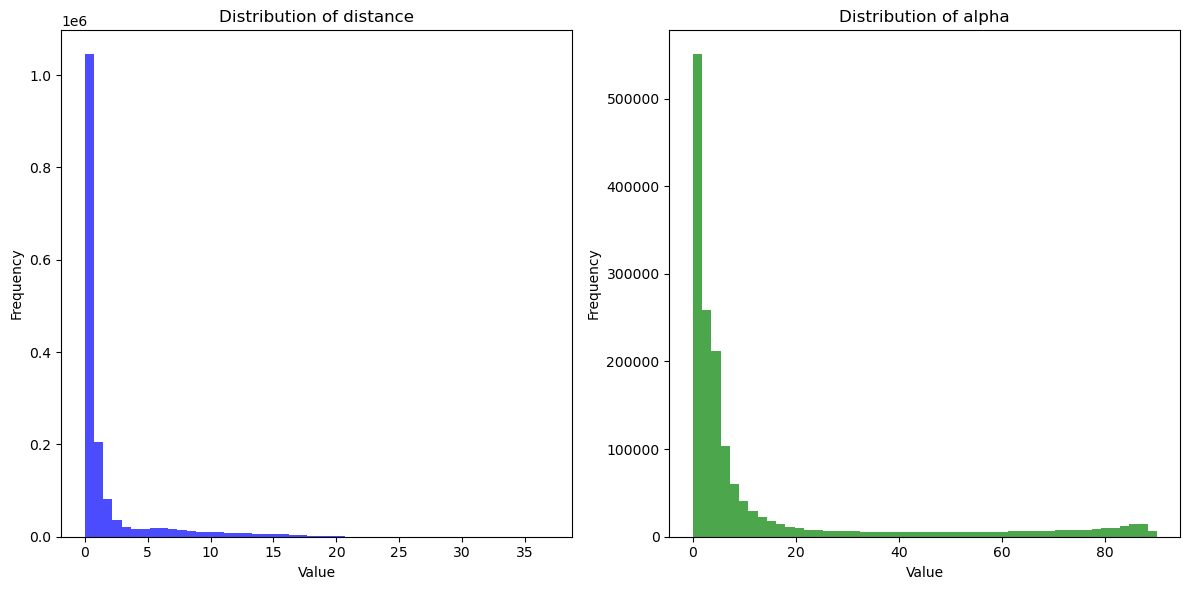

In [15]:
import matplotlib.pyplot as plt


data_1 = [item[1] for item in results if item[1] is not None]
data_2 = [item[2] for item in results if item[2] is not None]


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(data_1, bins=50,color='blue', alpha=0.7)
plt.title('Distribution of distance')
plt.xlabel('Value')
plt.ylabel('Frequency')


plt.subplot(1, 2, 2)
plt.hist(data_2, bins=50, color='green', alpha=0.7)
plt.title('Distribution of alpha')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

We can find that distance has a sharp drop from 0 to 3, and alpha also has a sharp drop from 0 to 5. Let's take a closer look at them.

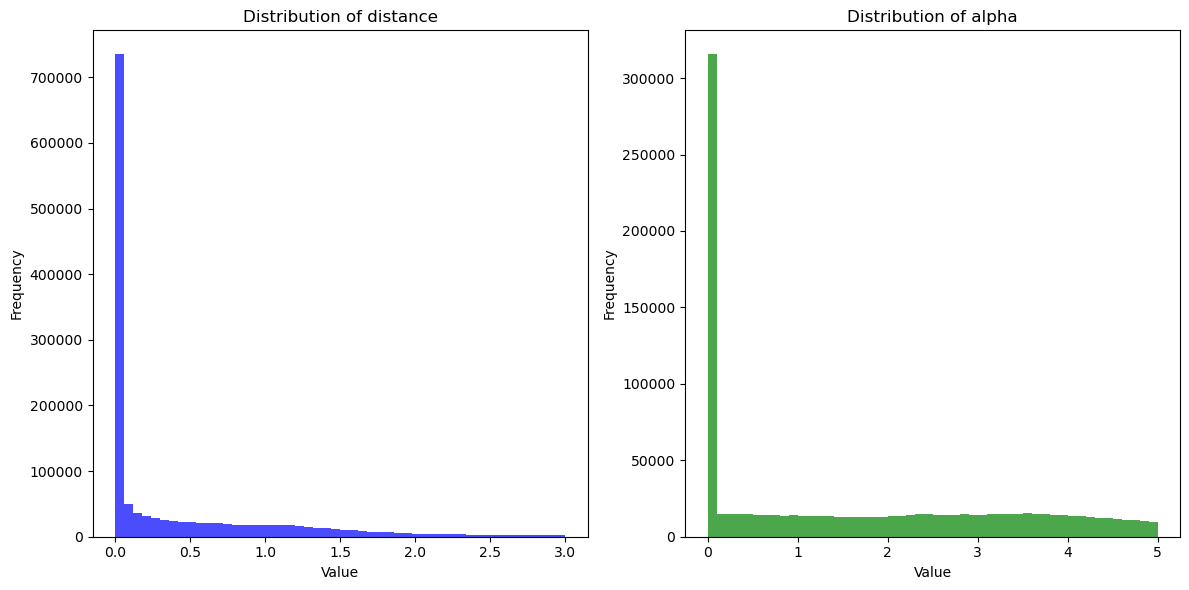

In [32]:
import matplotlib.pyplot as plt




data_1 = [item[1] for item in results if item[1] is not None]
data_2 = [item[2] for item in results if item[2] is not None]


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(data_1, bins=50,range=(0,3),color='blue', alpha=0.7) # set the range!!!
plt.title('Distribution of distance')
plt.xlabel('Value')
plt.ylabel('Frequency')


plt.subplot(1, 2, 2)
plt.hist(data_2, bins=50, range=(0,5),color='green', alpha=0.7) # set the range!!!
plt.title('Distribution of alpha')
plt.xlabel('Value')
plt.ylabel('Frequency')


plt.tight_layout()
plt.show()

We sort the points from small to large. The None value is infinite.

*Sorry, the local record data (results) are lost, so I grabbed it from the csv file.

In [9]:
import pandas as pd

def find_nth_smallest_value(file_path, n):

    df = pd.read_csv(file_path)


    df['distance'] = df['distance'].fillna(float('inf'))
    df['alpha'] = df['alpha'].fillna(float('inf'))


    df_sorted_by_col5 = df.sort_values(by='distance')
    df_sorted_by_col6 = df.sort_values(by='alpha')


    if n > len(df):
        return "too big"


    nth_smallest_col5 = df_sorted_by_col5.iloc[n-1]['distance']
    nth_smallest_col6 = df_sorted_by_col6.iloc[n-1]['alpha']

    return nth_smallest_col5, nth_smallest_col6


file_path_csv = '600_GP_output.csv' 
n = 1516921
print(find_nth_smallest_value(file_path_csv, n))

(9.722143221605222, 76.05652640068469)


In [12]:
n = 800000
print(find_nth_smallest_value(file_path_csv, n))

(0.1440245085104834, 3.5372362416385155)


We can see that if we use the number of AHN class 2 points, the distance and alpha will be too large. 
The ground should be less likely to suddenly rise by 9 meters.

If try cutting 1.5 million in half. With n=800,000 points, the data is similar to the threshold we set, except that we use "and" instead of just independent sorting as in the sorting method, so the actual point set generated It will definitely be smaller.

Judging from the chart, the threshold we set is quite feasible.

## Conclusion

The alpha value and distance value will be recorded in our code. Our threshold setting here is the result of using 0.1 thining. After re-verification, it was found that the threshold can be adjusted higher, but it is still within a reasonable range.

If we look at it in terms of AHN points, the threshold would be very unreasonable and would not be a ground point at all.

Since we have recorded the distance value and alpha value, if we adjust the array slightly, we can add points, such as filtering the distance value and alpha value of each data, making the threshold larger, so that more points become real. But it should be noted that this algorithm is a **greedy algorithm**, which means that the order of insertion of points will affect the final result. Subsequent adjustments to the array do not change the TIN. So it's not the most ideal method.

Therefore, if we want to reset the threshold, ideally we should rerun it.
